## LLM

In [42]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [43]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [44]:
def fuse_tokenized_corpus(corpus, tokenizer):
    SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
    EOS = tf.convert_to_tensor([[tokenizer.token_to_idx["</s>"]]])

    corpus_list = [SOS]
    for line in tqdm(corpus):
        corpus_list.append(line)
        corpus_list.append(EOS)
        corpus_list.append(SOS)

    corpus = tf.concat(corpus_list[:-1], axis=1)
    return corpus


def chunk_and_batch(corpus, chunk_size, batch_size, shuffle=True, repeat=False):
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.batch(chunk_size, drop_remainder=True)
    if shuffle:
        ds = ds.shuffle(buffer_size=100*chunk_size, reshuffle_each_iteration=True)
        
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    if repeat:
        ds = ds.repeat()

    return ds

In [45]:
max_seq_len = 768

tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()
tokenizer.pre_merge_list = []
tokenizer.add_special_tokens(["<s>", "</s>"])
tokenizer.create_hash()

In [6]:
#random.seed(43)
#corpus = pkl.load(open('corpus/CNN_tokenized16000_lowercase.pkl', 'rb'))
#random.shuffle(corpus)
#length = len(corpus)
#train_corpus = corpus[:int(length*0.8)]
#train_corpus = fuse_tokenized_corpus(train_corpus, tokenizer)

#test_corpus = corpus[int(length*0.8):]
#test_corpus = fuse_tokenized_corpus(test_corpus, tokenizer)


In [7]:
#pkl.dump(train_corpus, open('corpus/CNN_train_fused.pkl', 'wb'))
#pkl.dump(test_corpus, open('corpus/CNN_test_fused.pkl', 'wb'))

In [46]:
train_corpus = pkl.load(open('corpus/CNN_train_fused.pkl', 'rb'))
test_corpus = pkl.load(open('corpus/CNN_test_fused.pkl', 'rb'))

ds_train = chunk_and_batch(train_corpus[0], chunk_size=max_seq_len, batch_size=24, shuffle=True, repeat=True)
ds_test = chunk_and_batch(test_corpus[0], chunk_size=max_seq_len, batch_size=8, shuffle=True, repeat=True)

## Define Model

In [47]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)


embed_dim = 500
tf_blocks = 10
heads = 10
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    )

losses_train = []
losses_test = []


In [48]:
name = "model_16k_CNN_10blocks_10heads"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [44]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [49]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 38481072


In [50]:
def train_loop(ds_train, ds_test):
    for i, (batch_train, batch_test) in tqdm(enumerate(zip(ds_train, ds_test))):
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(loss_train, loss_test, lr)
    return losses_train, losses_test

In [51]:
train_loop(ds_train, ds_test)

0it [00:00, ?it/s]

KeyboardInterrupt: 

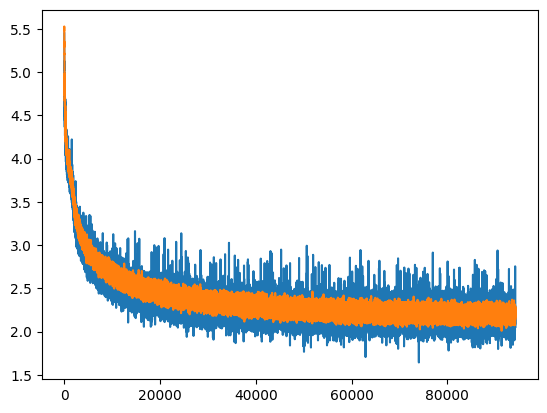

In [66]:
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")

In [70]:
text = ""
text = text.lower()
SOS = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
indices = tf.cast(tokenizer.encode(text), tf.int32)
indices = tf.concat([SOS, indices], axis=1)
print(indices)

tf.Tensor([[16070]], shape=(1, 1), dtype=int32)


In [71]:
import textwrap
import ipywidgets as widgets
from IPython.display import display

T = 0.7
tf.random.set_seed(45)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(768):
    logits = model.call(indices)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    )
    indices = tf.concat([indices, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(indices)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

In [74]:
text = "obama"
text = text.lower()

indices = tf.cast(tokenizer.encode(text), tf.int32)
print(indices)

T = 0.5
tf.random.set_seed(43)
for i in range(128):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.decode(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


tf.Tensor([[553]], shape=(1, 1), dtype=int32)


In [77]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters, normalize=True):
    if normalize:
        X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed, normalize=True):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters, normalize)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed, normalize)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.decode(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")


def cosine_similarity(embed_a, embed_b, normalize=True):
    """
    Compute the cosine similarity between two vectors.
    """
    if normalize:
        embed_a = tf.nn.l2_normalize(embed_a, axis=1)
        embed_b = tf.nn.l2_normalize(embed_b, axis=1)
    dot_product = embed_a@tf.transpose(embed_b)


    return dot_product

In [78]:
word_embed = model.word_embed
embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=100)
embedding_clustering.fit(word_embed, normalize=True)
embedding_clustering.print_clusters(n_words=10)

luis
javier
roberto
alberto
jorge
nicolas
christop
lionel
pablo
frances


confis
engul
satis
eclip
horri
absor
compe
subur
contem
depri


connect
connects
connection
links
relation
subscribe
linking
contributed
interact
linked


repression
persecution
injustice
resentment
intimidation
outrage
discrimination
atrocities
instability
discontent


silly
weird
delicious
funny
gorgeous
lovely
creepy
magical
bizarre
sexy


espion
couver
ailand
enthusia
theastern
portra
glary
usalem
riculum
hrir


br
sp
scr
sc
sn
pl
cr
stub
sh
gr


35
28
25
27
15
34
26
36
33
40


kno
sli
maneu
manife
scul
reco
impro
scri
engul
bli


provide
raise
bring
give
keep
reduce
protect
deliver
attract
make


scand
scrut
gior
satis
alv
mathem
chry
veter
obst
fitz


acknowledged
warned
insisted
cautioned
argued
suggested
explained
noted
urged
advised


daniels
jeffs
blagojevich
levine
sanders
delaw
peters
connell
toobin
hinckley


putting
taking
bringing
providing
giving
pulling
gaining
getting
delivering
raising


empath

# Overlap

In [79]:
word_embed = model.word_embed

text = "russia"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed1 = tf.expand_dims(word_embed[idx[0][0]], axis=0)


text = "putin"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed2 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed3 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

embed = embed1 - embed2 + embed3

cosine_sim = cosine_similarity(embed, word_embed, normalize=False)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

NameError: name 'tokenize' is not defined

In [ ]:
word_embed = model.word_embed

text = "obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenize(text), tf.int32)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[553]], shape=(1, 1), dtype=int32)
obama
obama's
clinton
romney
republicans
bush
boehner
sen
reagan
democrats
barack
mccain
congressional
sarkozy
pentagon
putin
u
assad
liberals
afghans
calderon
washington
bush's
conservatives
president
obamacare
iraqis
panetta
snowden
mcconnell
clinton's
chavez
gop
palin
americans
senate
christie
isis
veterans
he
voters
petraeus
pelosi
secretary
jindal
george
mandela
republican
kerry
karzai
biden
gop's
francis
economists
lawmakers
jeb
we've
congressman
rouhani
navarrette
congress
netanyahu
latinos
nixon
aides
iraqi
nra
pelos
richard
white
clint
gov
lincoln
romney's
gingrich
taxpayers
nato
presidents
vietnam
nieto
analysts
president's
ryan
gupta
senators
cdc
shinse
brennan
next
capitol
legislators
ahmadinejad
elect
erdogan
afghanistan
iraq
gadhafi
roosevelt
cheney
santorum


In [ ]:
word_embed = model.word_embed

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
abulary
hagel
maduro
espion
yingluck
onsored
nandez
saleh
natur
ailand
hezbol
panetta
biden
shinse
kerry
gibbs
sarkozy
fundam
hift
patro
signific
anonymity
putin
mugabe
lades
boehner
pelosi
medvedev
ahmadinejad
warri
thaksin
landrieu
shaba
gbag
accust
charac
fahren
liby
peninsu
helicop
zuma
traged
portugu
morsy
publ
enjo
ilight
abbas
erdogan
ieval
bachmann
yanukovych
leep
confir
rodrigue
secutive
provin
mccain's
moil
subsequ
abled
juvent
o'ne
guardiola
lieberman
karzai
catastro
ouatt
zardari
possib
toug
theless
burma
carney
ricul
zhok
barcelon
dort
sunnis
lomb
snowden
avez
diffic
sess
khamenei
exer
golese
copen
rouhani
ipal
transparen
ultane
mccain
boeh
diox
citiz
adjac
nieto
lavrov


## Mean Pooling

In [ ]:
word_embed = model.word_embed

text = "Obama's remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb."
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx.shape)
embed_final = model.call(idx, logits=False)
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32) 

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


(1, 62)
 
.
-
"
,
a
in


and
the
on
to
at
'
an
or
u
by
that
:
as
's
s
al
of
it
he
for
un
over
e
about
is
with
after
up
not
last
more
may
?
re
from
ad
(
state
be
just
so
was
one
/
ed
no
war
while
security
;
but
1
en
n
man
house
i
north
m
first
ar
l
f
c
er
there
out
o
do
two
when
less
had
air
k
v
h
near
they
2
his
some
de
back
we
field
fire
if
this
under
p
right


In [ ]:
word_embed = model.word_embed

text = "Obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
b = model.unembed_b[idx[0][0]]
print(b)
logits = model.call(idx, logits=True) 
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32)

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(logits, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(i)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


tf.Tensor([[553]], shape=(1, 1), dtype=int32)
tf.Tensor(0.08745351, shape=(), dtype=float32)
tf.Tensor([[    1    13    15 ... 15466  9736 15505]], shape=(1, 16070), dtype=int32)


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

In [ ]:
text = "this is a text to find out how to make a stop mask"
text = text.lower()
tokens = tokenizer.encode(text)
tokens.insert(0, tokenizer.token_to_idx["<s>"])
tokens.insert(10, tokenizer.token_to_idx["</s>"])
tokens.insert(10, tokenizer.token_to_idx["<s>"])
tokens.insert(15, tokenizer.token_to_idx["</s>"])
tokens.insert(15, tokenizer.token_to_idx["<s>"])
tokens.append(tokenizer.token_to_idx["</s>"])

print(tokens)




NameError: name 'tokenizer' is not defined

## 